In [1]:
import os
import random
import shutil
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from constants import DATA_DIR, MODEL_PATH, IMG_SIZE, MEAN, STD
from train import SimpleCNN

In [2]:
if torch.backends.mps.is_available():
        device = torch.device("mps")
else:
    device = torch.device("cpu")

model = SimpleCNN(num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

/var/folders/6y/5lm4_4ld2x783v2_w4llgl080000gn/T/ipykernel_62571/3924074928.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, 

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [3]:
transform_for_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])
test_dir = os.path.join(DATA_DIR, 'test')
test_dataset = datasets.ImageFolder(test_dir, transform=transform_for_test)
class_names = test_dataset.classes
class_to_idx = test_dataset.class_to_idx

num_images_per_class = 15
selected_images = []

random.seed(42)

for class_name in class_names:
    class_idx = class_to_idx[class_name]
    indices = [i for i, (_, label) in enumerate(test_dataset) if label == class_idx]
    selected = random.sample(indices, min(num_images_per_class, len(indices)))
    selected_images.extend(selected)

print(f"Selected {len(selected_images)} images for testing")

Selected 30 images for testing


FileNotFoundError: [Errno 2] No such file or directory: 'data/test/bottle/IMG_4028.jpg'

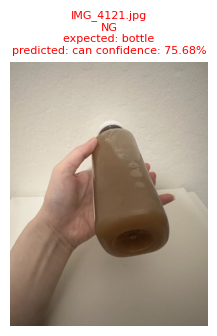

In [5]:
softmax = nn.Softmax(dim=1)

num_cols = 5
num_rows = int(np.ceil(len(selected_images) / num_cols))

plt.figure(figsize=(20, num_rows * 4))

for i, idx in enumerate(selected_images):
    image_path, true_label = test_dataset.imgs[idx]
    image_name = os.path.basename(image_path)
    class_name = class_names[true_label]
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform_for_test(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = softmax(output)
        confidence, predicted_idx = torch.max(probabilities, 1)
        predicted_label = predicted_idx.item()
        predicted_class = class_names[predicted_label]
        confidence_percent = confidence.item() * 100
        is_correct = predicted_label == true_label
    
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
    color = 'green' if is_correct else 'red'
    plt.title(f"{image_name}\n{'OK' if is_correct else 'NG'}\nexpected: {class_name}\npredicted: {predicted_class} confidence: {confidence_percent:.2f}%", 
              color=color, fontsize=8)
    
plt.tight_layout()
plt.show()